# Overview

Welcome to the assignment notebook of Sándor Gregus, Katalin Ócsai (EW9A0Z), and József Mátyás Prechl!

We decided to work on a larger and simpler database: CelebA.
We have reviewed not only the recommended GAN literature (https://paperswithcode.com/paper/progressive-growing-of-gans-for-improved )
but also VAEs and beta VAEs.




* Chosen topic:

*Cél:  Az arckép jellemzőinek a felismerése. Első lépésben címkézett adatok alapján az adatbázisban található címkékre készítsetek minél jobb modellt. További opcionális lépésként VAE (és/vagy GAN) alapú architektúrával célszerű kísérletezni, hogy a látens változók milyen arc jellemzőket tanulnak meg - akár felismerés, akár generálás idején.* 

*Előny: könnyű nagy mennyiségű adatot beszerezni; de mégis a jó minőségű képek szintéziséhez sok trükk kell*

*Kiindulás: https://paperswithcode.com/paper/progressive-growing-of-gans-for-improved* 

*Adatbázis: https://github.com/dchen236/FairFace, de mást is lehet használni*



*   *Tasks*: 

*   *Adatok beszerzése, adatfeltárás, vizualizáció (ha szükséges) és előkészítés tanításhoz*
*   *Eredmény: tanító, validációs és teszt adatbázisok*

# Download data



Easier access to CelebA database from our own Google Drive.
Unzipping more than 200k files from the zip takes less than a minute.

In [42]:
!mkdir celebA

In [43]:
%cd celebA

/content/celebA/celebA


In [44]:
!gdown --id 1uy2L1qT4kR8QWh6W0TEBqPuezMvJChgW

Downloading...
From: https://drive.google.com/uc?id=1uy2L1qT4kR8QWh6W0TEBqPuezMvJChgW
To: /content/celebA/celebA/img_align_celeba.zip
100% 1.44G/1.44G [00:19<00:00, 72.7MB/s]


In [45]:
!gdown --id 1nDQffbFImz9mmuRdBIm9_3adOQBZ8rY3

Downloading...
From: https://drive.google.com/uc?id=1nDQffbFImz9mmuRdBIm9_3adOQBZ8rY3
To: /content/celebA/celebA/list_attr_celeba.csv
100% 24.9M/24.9M [00:00<00:00, 53.4MB/s]


In [46]:
!unzip img_align_celeba.zip

A streamkimeneten csak az utolsó 5000 sor látható.
 extracting: img_align_celeba/197600.jpg  
 extracting: img_align_celeba/197601.jpg  
 extracting: img_align_celeba/197602.jpg  
 extracting: img_align_celeba/197603.jpg  
 extracting: img_align_celeba/197604.jpg  
 extracting: img_align_celeba/197605.jpg  
 extracting: img_align_celeba/197606.jpg  
 extracting: img_align_celeba/197607.jpg  
 extracting: img_align_celeba/197608.jpg  
 extracting: img_align_celeba/197609.jpg  
 extracting: img_align_celeba/197610.jpg  
 extracting: img_align_celeba/197611.jpg  
 extracting: img_align_celeba/197612.jpg  
 extracting: img_align_celeba/197613.jpg  
 extracting: img_align_celeba/197614.jpg  
 extracting: img_align_celeba/197615.jpg  
 extracting: img_align_celeba/197616.jpg  
 extracting: img_align_celeba/197617.jpg  
 extracting: img_align_celeba/197618.jpg  
 extracting: img_align_celeba/197619.jpg  
 extracting: img_align_celeba/197620.jpg  
 extracting: img_align_celeba/197621.jpg  
 ex

# Get the attributes and do some exploration of the data



*   We checked whether the table of attributes contains empty values
*   We checked whether the table of attributes contains only binary values
*   We checked whether the image database contains (quasi)constant images
*   We checked whether the size of image database matches the size of attribute table



To check the data and attributes we decided to use pandas package.
We imported the table of attributes and had a quick sanity check.

In [47]:
import pandas as pd

In [48]:

# import the data set that includes the attributes for each picture
df_attr = pd.read_csv('list_attr_celeba.csv', sep=';')
df_attr.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
df_attr.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,1,0,0,0,1,1,0,1,0,1,0,0,1
1,000002.jpg,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2,000003.jpg,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
3,000004.jpg,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,1,0,1
4,000005.jpg,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1


Checking for empty / null values in the table

In [8]:
import numpy as np
np.where(pd.isnull(df_attr))

(array([], dtype=int64), array([], dtype=int64))

Checking the different values for each binary attributes. 
We found that all of them were 2 (as it should be)

In [49]:
df2 = pd.DataFrame(df_attr)
df2.nunique()

image_id               202599
5_o_Clock_Shadow            2
Arched_Eyebrows             2
Attractive                  2
Bags_Under_Eyes             2
Bald                        2
Bangs                       2
Big_Lips                    2
Big_Nose                    2
Black_Hair                  2
Blond_Hair                  2
Blurry                      2
Brown_Hair                  2
Bushy_Eyebrows              2
Chubby                      2
Double_Chin                 2
Eyeglasses                  2
Goatee                      2
Gray_Hair                   2
Heavy_Makeup                2
High_Cheekbones             2
Male                        2
Mouth_Slightly_Open         2
Mustache                    2
Narrow_Eyes                 2
No_Beard                    2
Oval_Face                   2
Pale_Skin                   2
Pointy_Nose                 2
Receding_Hairline           2
Rosy_Cheeks                 2
Sideburns                   2
Smiling                     2
Straight_H

Checking for the number of rows, which must be the same as the number of images (as we saw 202599)

In [50]:
df_attr.shape

(202599, 41)

In [51]:
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

In [52]:
import random
import os
import csv
import numpy as np

crsPath = 'img_align_celeba'

We choose a random image example and checked all the attributes

,Receding_Hairline,Double_Chin,Chubby,Big_Lips,Blurry,Goatee,Male,Mustache,Big_Nose,Wearing_Necktie,5_o_Clock_Shadow,Arched_Eyebrows,Sideburns,Oval_Face,Narrow_Eyes,Wearing_Hat,Rosy_Cheeks,Heavy_Makeup,Pale_Skin,Wearing_Lipstick,Brown_Hair,Eyeglasses,Wavy_Hair,Straight_Hair,Mouth_Slightly_Open,High_Cheekbones,Wearing_Necklace,image_id,Bald,Attractive,Black_Hair,Gray_Hair,Smiling,Bangs,Wearing_Earrings,Blond_Hair,Bags_Under_Eyes,Pointy_Nose,No_Beard,Bushy_Eyebrows,Young
70575,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,1,1,070576.jpg,0,1,0,0,1,0,0,1,0,1,1,0,1


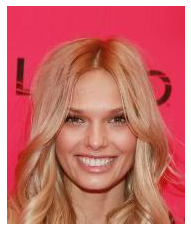

In [53]:
img_name = random.choice(os.listdir(crsPath))
img = load_img(crsPath + os.sep + img_name)
plt.grid(False)
plt.axis('off')
plt.imshow(img)
df_attr.loc[df_attr['image_id'] == img_name][random.sample(list(df_attr.columns), len(df_attr.columns))[:]] 

# Split the dataset to train/test/val data

To split the dataset we used random permutation of the data in the ration of 0.8: 0.1 : 0.1
Then we checked whether the distribution of train / test / split are the same in the different attributes.
We save the split file for checking the data later if necessary

In [54]:
#setup ratio (val ratio = rest of the files in origin dir after splitting into train and test)
train_ratio = 0.8
test_ratio = 0.1


#total count of imgs
totalImgCount = len(os.listdir(crsPath))
print("total img count:", totalImgCount)
countForTrain = int(totalImgCount*train_ratio)
countForTest = int(totalImgCount*test_ratio)
countForValid = totalImgCount - countForTrain - countForTest

print("train count:", countForTrain)
print("test count:", countForTest)
print("val count:", countForValid)
randPermute = np.random.permutation(totalImgCount)

with open('list_eval_partition.csv','w') as f:
    writer = csv.writer(f)

    #cycle for train dir
    for x in range(countForTrain):
        counter = randPermute[x]
        writer.writerow(['{:06}'.format(counter+1)+'.jpg','0'])

    #cycle for test dir
    for x in range(countForTest):
        counter = randPermute[countForTrain + x]
        writer.writerow(['{:06}'.format(counter+1)+'.jpg','1'])    

    #cycle for valid  dir
    for x in range(countForValid):
        counter = randPermute[countForTrain + countForTest + x]
        writer.writerow(['{:06}'.format(counter+1)+'.jpg','2'])

total img count: 202599
train count: 162079
test count: 20259
val count: 20261


We read back split file

In [55]:
df_split = pd.read_csv('list_eval_partition.csv', names=['image_id', 'split'])

In [56]:
df_buff = df_attr.merge(df_split, on=["image_id"])
df_buff = df_buff.sort_index()
df_buff.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,split
0,000001.jpg,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,1,0,0,0,1,1,0,1,0,1,0,0,1,1
1,000002.jpg,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,000003.jpg,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
3,000004.jpg,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,1,0,1,1
4,000005.jpg,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1


We split data to different dataframes(train, test, vlaidation)

In [57]:
df_train = df_buff[df_buff['split'] == 0]
df_test = df_buff[df_buff['split'] == 1]
df_val = df_buff[df_buff['split'] == 2]

We check the percentage of different attributes

In [58]:
train_attr_perc = df_train.drop(columns=['split', 'image_id']).apply(pd.value_counts, normalize=True).drop(0)
test_attr_perc = df_test.drop(columns=['split', 'image_id']).apply(pd.value_counts, normalize=True).drop(0)
val_attr_perc = df_val.drop(columns=['split', 'image_id']).apply(pd.value_counts, normalize=True).drop(0)

In [59]:
print(train_attr_perc)

   5_o_Clock_Shadow  Arched_Eyebrows  ...  Wearing_Necktie     Young
1          0.111224          0.26745  ...         0.072878  0.773327

[1 rows x 40 columns]


In [60]:
print(val_attr_perc)

   5_o_Clock_Shadow  Arched_Eyebrows  ...  Wearing_Necktie     Young
1          0.112038         0.261784  ...         0.072208  0.774937

[1 rows x 40 columns]


In [61]:
print(test_attr_perc)

   5_o_Clock_Shadow  Arched_Eyebrows  ...  Wearing_Necktie     Young
1          0.109532         0.268424  ...         0.071919  0.774619

[1 rows x 40 columns]


We put them into one common table and checked the similar distribution of attributes in case of the three partitions

In [62]:
df_plot = train_attr_perc.transpose().join(test_attr_perc.transpose(), lsuffix='train', rsuffix='test').join(val_attr_perc.transpose())
df_plot.columns = ['train', 'test', 'val']
df_plot.head()

,train,test,val
5_o_Clock_Shadow,0.111224,0.109532,0.112038
Arched_Eyebrows,0.267450,0.268424,0.261784
Attractive,0.512707,0.508663,0.514733
Bags_Under_Eyes,0.204067,0.206180,0.206999
Bald,0.022236,0.023150,0.023395


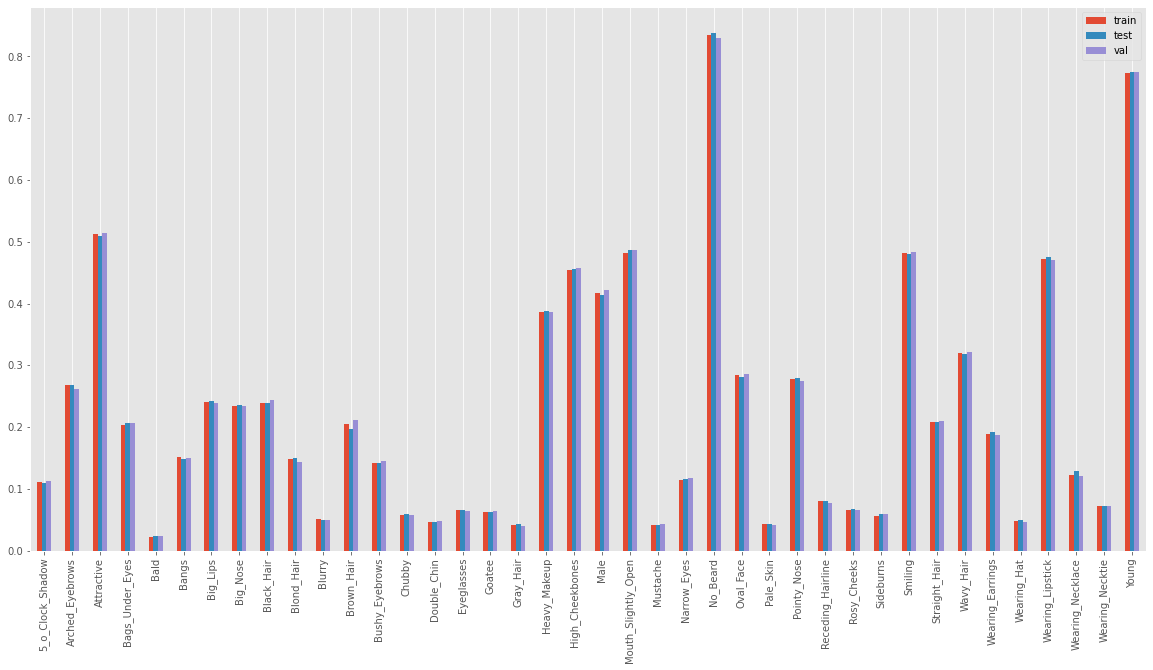

In [63]:
df_plot.plot(kind='bar', figsize=(20,10)).grid(axis='y')

# Preprocessing of the data
Before normalize the images we checked the standard deviation of red, green, blue channels so that to avoid division by a very small number (and using quasi-constant images)

In [64]:
# set variables 
main_folder = '../input/celebA/'
images_folder = main_folder + 'img_align_celeba/'

EXAMPLE_PIC = images_folder + '002806.jpg'

EPSILON = 0.001 # for checking the std of images
TRAINING_SAMPLES = 10000
VALIDATION_SAMPLES = 2000
TEST_SAMPLES = 2000
IMG_WIDTH = 178
IMG_HEIGHT = 218
BATCH_SIZE = 16
NUM_EPOCHS = 20


We checked whether the dataset contain any quasi-constant images (or image with quasi-constant channels). 
We found that there is no such image

In [65]:
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import glob

# folder for the dataset 
imdir = '/content/celebA/img_align_celeba'

files = []
ext = ['jpg']
[files.extend(glob.glob(imdir + '/*.' + e)) for e in ext]

# channels for RGB images
channels = ['RED', 'GREEN', 'BLUE']
i = 0
with open('MeanStdPerChannels.csv','w') as f:
  writer = csv.writer(f)
  for file in files: # iteration on files in the folder
    image = io.imread(file)
    stdr = np.std(image[:, :, 0])
    stdg = np.std(image[:, :, 1])
    stdb = np.std(image[:, :, 2])
    fn = os.path.basename(file)
    if stdr<EPSILON or stdg<EPSILON or stdb<EPSILON:
      print(fn)
      writer.writerow([fn, stdr, stdg, stdb])

In [66]:
import pandas as pd
import numpy as np
import cv2    
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
#from keras.optimizers import SGD
from tensorflow.keras.optimizers import SGD

from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64

plt.style.use('ggplot')

%matplotlib inline

Checking the version of Tensorflow

In [67]:
import tensorflow as tf
print(tf.__version__)

2.6.0


Choosing a random image with random.choice

In [68]:
img_name = random.choice(os.listdir(crsPath))


## Data Augmentation with rotation, shifting, shearing, zooming,

We decided to try to augment training and validation set with the ImageDataGenerator function from Tensorflow

In [69]:
datagen =  ImageDataGenerator(
  horizontal_flip=True,
  rotation_range=30,
  zoom_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  width_shift_range=0.2
)

We load an image into an array, we normalized and intruduce a new dimension it

In [70]:
def load_reshape_img(fname):
    img = load_img(fname)
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)

    return x

In [71]:
x = load_reshape_img(crsPath + os.sep + img_name)

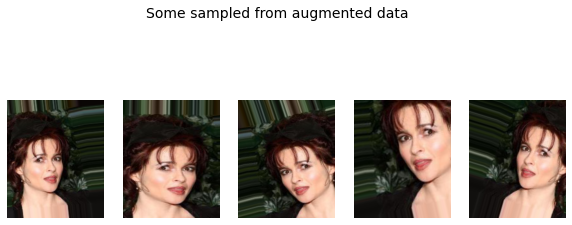

In [72]:
# plot 5 augmented images of the loaded image
plt.figure(figsize=(10,10))
plt.suptitle('Some sampled from augmented data', fontsize=14)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(3, 5, i+1)
    plt.grid(False)
    plt.axis('off')
    plt.imshow( batch.reshape(IMG_HEIGHT, IMG_WIDTH, 3))
    
    if i == 4:
        break
    i += 1
    
plt.show()

In [73]:
def generate_dataframes(partition, attr, num_samples):
# partition 0 - train;  1 -validation;  2 - test
    
    df_ = df_attr[(df_attr['split'] == partition) 
                           & (df_attr[attr] == 0)].sample(int(num_samples/2))
    df_ = pd.concat([df_,
                      df_attr[(df_attr['split'] == partition) 
                                  & (df_attr[attr] == 1)].sample(int(num_samples/2))])

    # for Train and Validation
    if partition != 2:
        x_ = np.array([load_reshape_img(imdir +'/'+ fname) for fname in df_.index])
        x_ = x_.reshape(x_.shape[0], IMG_HEIGHT, IMG_WIDTH, 3)
        y_ = np_utils.to_categorical(df_[attr],2)
    # for Test
    else:
        x_ = []
        y_ = []

        for index, target in df_.iterrows():
            im = cv2.imread(images_folder + index)
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
            im = np.expand_dims(im, axis =0)
            x_.append(im)
            y_.append(target[attr])

    return x_, y_

In [74]:
df_attr.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,1,0,0,0,1,1,0,1,0,1,0,0,1
1,000002.jpg,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2,000003.jpg,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
3,000004.jpg,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,1,0,1
4,000005.jpg,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1


In [75]:
df_attr = df_buff

In [76]:
df_attr.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,split
0,000001.jpg,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,1,0,0,0,1,1,0,1,0,1,0,0,1,1
1,000002.jpg,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,000003.jpg,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
3,000004.jpg,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,1,0,1,1
4,000005.jpg,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1


In [77]:
df_attr.set_index('image_id', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
df_attr.shape

(202599, 41)

We have different augmented datasets for the different kind of attributes

In [78]:
# Train data for discremenate gender
x_train, y_train = generate_dataframes(0, 'Heavy_Makeup', 1000)

# Train - Data Preparation - Data Augmentation with generators
train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(
x_train, y_train,
batch_size=BATCH_SIZE,
)

Check whether train_generator is a valid ImageDataGenerator object 

In [79]:
print(train_datagen)

In [80]:
# Validation Data
x_valid, y_valid = generate_dataframes(1, 'Male', VALIDATION_SAMPLES)


# Validation - Data Preparation - Data Augmentation with generators
valid_datagen = ImageDataGenerator(
  preprocessing_function=preprocess_input,
)

valid_datagen.fit(x_valid)

validation_generator = valid_datagen.flow(
x_valid, y_valid,
)


<a href="https://colab.research.google.com/github/Kata5/DeepLearning2021/blob/main/DeepLearning2021_Milestone01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>